In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
# from https://stackoverflow.com/a/47042430
# gives us points s.t. the distance between any 2 is at least 3
while True:
    P = (np.random.rand(10, 3) - 0.5) * 10 #[-5, 5] on each axis
    if all(np.linalg.norm(p - q) > 3
            for p, q in combinations(P, 2)):
        break

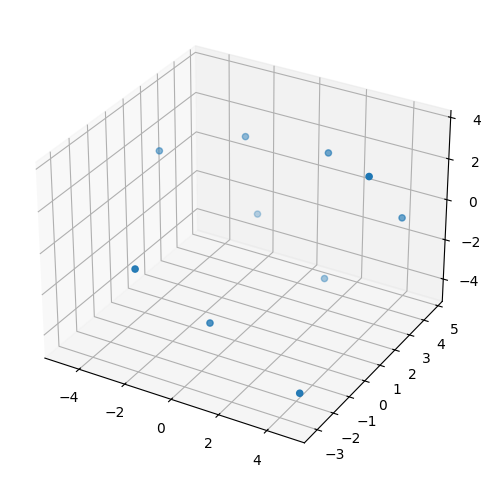

In [3]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(P[:, 0], P[:, 1], P[:, 2])

Viewing from different axes (test cameras)

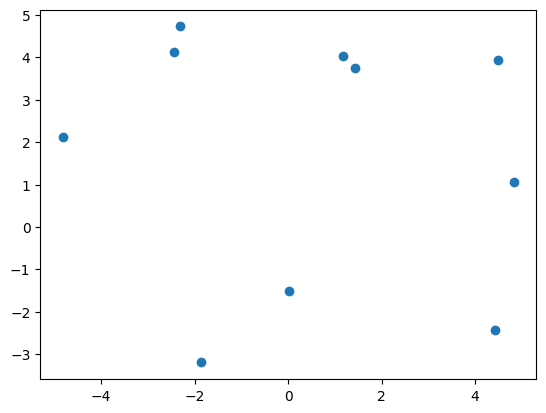

In [4]:
Z_ax_cam = P[:, :2]
plt.scatter(Z_ax_cam[:,0], Z_ax_cam[:, 1])

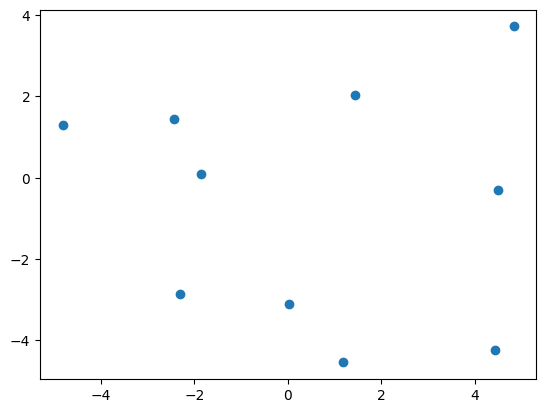

In [5]:
Y_ax_cam = P[:, [0, 2]]
plt.scatter(Y_ax_cam[:,0], Y_ax_cam[:, 1])

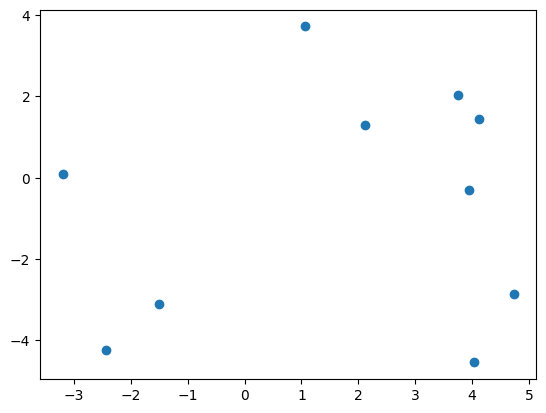

In [6]:
X_ax_cam = P[:, 1:]
plt.scatter(X_ax_cam[:,0], X_ax_cam[:, 1])

#### Update points example

In [7]:
d = 0.1
moves = d * np.random.choice([-1, 1], size=30).reshape((10, 3))
moves

array([[-0.1, -0.1,  0.1],
       [-0.1,  0.1,  0.1],
       [-0.1, -0.1, -0.1],
       [ 0.1, -0.1, -0.1],
       [-0.1,  0.1, -0.1],
       [-0.1,  0.1, -0.1],
       [ 0.1, -0.1,  0.1],
       [-0.1, -0.1,  0.1],
       [ 0.1, -0.1,  0.1],
       [-0.1,  0.1, -0.1]])

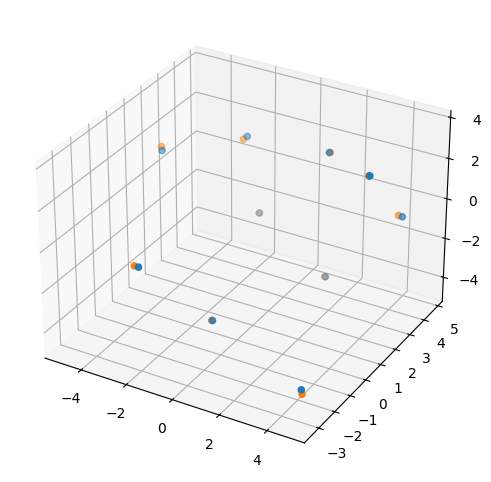

In [9]:
P_new = P + moves
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(P[:, 0], P[:, 1], P[:, 2])
ax.scatter(P_new[:, 0], P_new[:, 1], P_new[:, 2])

Update Points

In [10]:
clouds = [P]
N = 100
for i in range(N):
    moves = d * np.random.choice([-1, 1], size=30).reshape((10, 3))
    clouds.append(clouds[-1] + moves)

/var/folders/q_/vyck0rnj52s7g0k52c4p5jr40000gn/T/ipykernel_75050/3377799705.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=[i/N, 0, 1 - i/N])


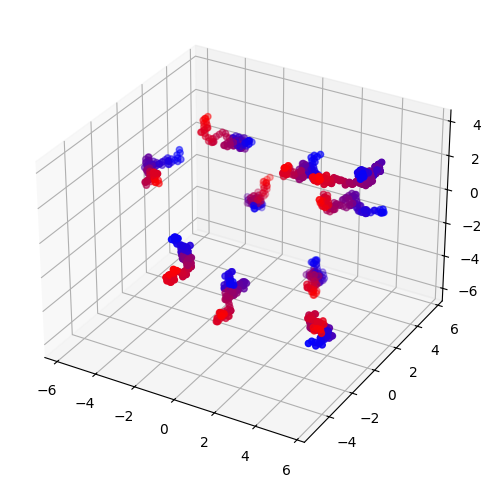

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
#smooth color transition from light to dark
for i in range(N):
    cloud = clouds[i]
    ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=[i/N, 0, 1 - i/N])

Project point cloud to arbitrary camera angle

In [17]:
#camera lookat function
def lookat(from_pt, to_pt):
    forward = to_pt - from_pt
    forward /= np.linalg.norm(forward)
    right = np.cross(forward, np.array([0, 0, 1]))
    right /= np.linalg.norm(right)
    up = np.cross(right, forward)
    up /= np.linalg.norm(up)
    return np.array([right, up, forward])

#test camera look at
from_pt = np.array([6, 6, 6], dtype=np.float64)
to_pt = np.array([0, 0, 0], dtype=np.float64)
lookat(from_pt, to_pt)

array([[-0.70710678,  0.70710678,  0.        ],
       [-0.40824829, -0.40824829,  0.81649658],
       [-0.57735027, -0.57735027, -0.57735027]])

Generate and project points

In [19]:
#use the lookat function to get the camera matrix
def camera_matrix(from_pt, to_pt):
    R = lookat(from_pt, to_pt)
    T = -R @ from_pt
    return np.column_stack([R, T])

# project points to 2D
def project(P, from_pt, to_pt):
    C = camera_matrix(from_pt, to_pt)
    P_hom = np.column_stack([P, np.ones(len(P))])
    return C @ P_hom.T  

/var/folders/q_/vyck0rnj52s7g0k52c4p5jr40000gn/T/ipykernel_75050/2823875745.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(projected[0], projected[1], c=[t/N, 0, 1 - t/N])


(100, 2, 10)

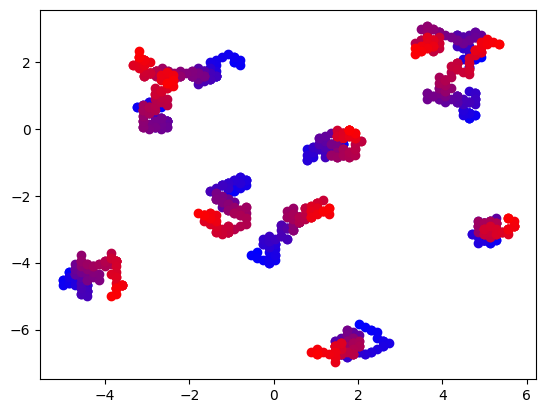

In [60]:
from_pt = np.array([6, 6, 6], dtype=np.float64)
to_pt = np.array([0, 0, 0], dtype=np.float64)
proj_cloud = []
for t in range(N):
    projected = project(clouds[t], from_pt, to_pt)
    proj_cloud.append(projected[:2])
    plt.scatter(projected[0], projected[1], c=[t/N, 0, 1 - t/N])

#make proj_clouds a numpy array
proj_clouds = np.array(proj_cloud)
proj_clouds.shape

Generate many random camera views along the unit sphere

In [42]:
def polar_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

num_cameras = 10
camera_data = []
for camera in range(num_cameras):

    #randomly sample a point on the sphere
    theta = np.random.rand() * np.pi
    phi = np.random.rand() * 2 * np.pi

    #convert to cartesian
    radius = np.sqrt(3 * 6**2)
    from_pt = polar_to_cartesian(radius, theta, phi)
    to_pt = np.array([0, 0, 0], dtype=np.float64)

    #project the cloud to 2D
    proj_clouds = []
    for t in range(N):
        projected = project(clouds[t], from_pt, to_pt)
        proj_clouds.append(projected[:2])

    proj_clouds = np.array(proj_clouds)
    camera_data.append((from_pt, to_pt, proj_clouds))

/var/folders/q_/vyck0rnj52s7g0k52c4p5jr40000gn/T/ipykernel_75050/579225290.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(proj_clouds[t, 0], proj_clouds[t, 1], c=[t/N, 0, 1 - t/N])


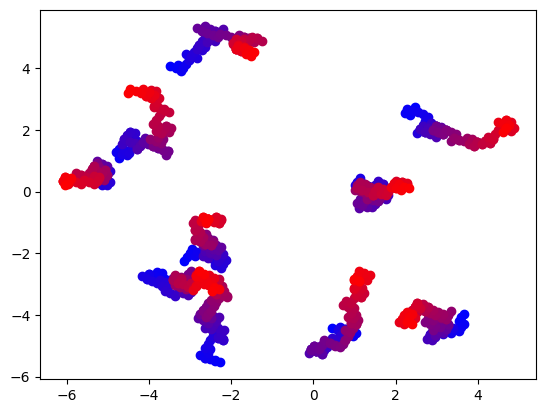

In [72]:
#plot one of the cameras
from_pt, to_pt, proj_clouds = camera_data[5]

# plot all frames for the first camera
for t in range(N):
    plt.scatter(proj_clouds[t, 0], proj_clouds[t, 1], c=[t/N, 0, 1 - t/N])